# Leaf segmentation and tracking prediction pipeline

This notebook shows how to run instance segmentation and leaf tracking on plant images using the pretrained detectron2 model and LapTrack package.

The results are saved as a **LabelMe annotation file**.  
  
### Instructions
- Select your data folder in **Run predictions** section
- If you have GPU access, change the `device` in **Load model** section
- The resulting segmentation and tracking will be stored in the Labelme json file
- If you want to save visualization images for the segmentation, change `save_visualization_images` parameter

### Mount your google drive

In [1]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


# Install packages

In [2]:
import distutils.core
import os
import sys

!pip install torch==2.2.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath("./detectron2"))
!python -m pip install pyyaml
!python -m pip install laptrack
!python -m pip uninstall numpy -y
!python -m pip install numpy==1.24.4

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 13.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=5d63341b6b13d1162f1fb211e5f92dd5af909b7f55d92cee23434376aebdd39d
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=fdb2ff917291fc3e2bddae8cf5692e4d5522dd9e8d9be75eb8f14c0950afc9fe
  Stored in directory: /root/.cache/pip/wheels/12/93/dd/1f6a

# Download model from Zenodo

In [18]:
!pip install zenodo_get
!zenodo_get 10.5281/zenodo.10838079

Title: AI4Life Open Calls: Project OC-74 resources
Keywords: 
Publication date: 2024-03-27
DOI: 10.5281/zenodo.10838079
Total size: 351.1 MB

Link: https://zenodo.org/records/10838079/files/model.pth   size: 351.1 MB

Checksum is correct. (802c8379bb496d2a96cf97e6035623e5)
All files have been downloaded.


# Import packages

In [4]:
import detectron2
import torch

!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

# Some basic setup:
# Setup detectron2 logger
from detectron2.utils.logger import setup_logger

setup_logger()

import json
from pathlib import Path

# import some common libraries
import cv2
import imageio.v2 as imageio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from laptrack import LapTrack
from matplotlib.colors import LinearSegmentedColormap
from skimage.color import label2rgb
from skimage.measure import regionprops_table
from skimage.transform import rescale
from tqdm import tqdm

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


# Main functions for prediction

## Code for segmentation

In [5]:
# load model, set prediction score threshold


def load_model(weights: str, device: str = "cpu", score_threshold: float = 0.75):
    cfg = get_cfg()
    cfg.merge_from_file(
        model_zoo.get_config_file(
            "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
        )
    )
    cfg.DATALOADER.NUM_WORKERS = 1
    cfg.MODEL.WEIGHTS = weights
    cfg.SOLVER.IMS_PER_BATCH = 1
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2
    cfg.MODEL.WEIGHTS = weights
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = (
        score_threshold  # set a custom testing threshold
    )
    cfg.MODEL.DEVICE = device
    predictor = DefaultPredictor(cfg)
    return predictor


# read image and scale it down
def prepare_image(image_path: Path, result_path: Path, scale_factor: float = 0.5):
    image = imageio.imread(image_path, pilmode="RGB")
    image = rescale(image, (scale_factor, scale_factor, 1))
    image = (image * 255).astype(np.uint8)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image


# if there are several plants predicted, leave only the central one
def find_central_plant_mask(plant_boxes: np.ndarray, plant_masks: np.ndarray):
    image_height, image_width = plant_masks.shape[1:]
    image_center = np.array([image_height / 2, image_width / 2])

    plant_centers = []
    for box in plant_boxes:
        l, t, r, b = box
        height = b - t
        width = r - l
        plant_centers.append((height // 2, width // 2))

    plant_centers = np.array(plant_centers)

    distance = np.linalg.norm(plant_centers - image_center, axis=1)
    best_plant_index = np.argmin(distance)
    central_plant_mask = plant_masks[best_plant_index]
    central_plant_mask = central_plant_mask.astype(np.uint8)

    return central_plant_mask


# Create instance masks and bboxes from detectron prediction
def get_masks_from_predictions(instances):
    leaf_masks, plant_masks = [], []
    plant_boxes = []
    for box, score, label, mask in zip(
        instances.pred_boxes,
        instances.scores,
        instances.pred_classes,
        instances.pred_masks,
    ):
        mask = mask.numpy()
        if label == 0:
            plant_masks.append(mask)
            plant_boxes.append(box)
        else:
            leaf_masks.append(mask)

    leaf_masks = np.array(leaf_masks)
    plant_masks = np.array(plant_masks)
    return plant_boxes, plant_masks, leaf_masks


# leave only leaves that belong to the central plant
def remove_other_plants(
    leaf_masks: np.ndarray, central_plant_mask: np.ndarray, min_overlap: float = 0.5
):
    central_plant_leaves_mask = []
    for leaf_mask in leaf_masks:
        intersection = np.sum(central_plant_mask * leaf_mask)
        leaf_area = np.sum(leaf_mask)
        overlap = intersection / leaf_area
        if overlap > min_overlap:
            central_plant_leaves_mask.append(leaf_mask)
    central_plant_leaves_mask = np.array(central_plant_leaves_mask)
    return central_plant_leaves_mask


# covert a set of instance masks to a single mask
def instance_masks_to_mask(instance_masks: np.ndarray, scale_factor: float = 1.5):
    mask_labels = np.arange(instance_masks.shape[0])
    mask_labels = mask_labels[..., None, None]
    mask_labels = mask_labels + 1
    result_mask = np.max(instance_masks * mask_labels, axis=0)
    result_mask = result_mask.astype(np.uint8)

    h, w = result_mask.shape
    new_h, new_w = int(h * scale_factor), int(w * scale_factor)
    result_mask = cv2.resize(
        result_mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST
    )

    return result_mask


# Create and save a Labelme file from an instance mask


def save_labelme_json(instance_mask: np.ndarray, image_name: str, result_path: Path):
    label_name = "leaf"

    image_height, image_width = instance_mask.shape
    labelme_json = {
        "version": "4.5.6",
        "flags": {},
        "shapes": [],
        "imagePath": image_name,
        "imageData": None,
        "imageHeight": image_height,
        "imageWidth": image_width,
    }

    values = np.unique(instance_mask)
    values = values[values > 0]
    for value in values:
        leaf_mask = (instance_mask == value).astype(np.uint8)
        contours, _ = cv2.findContours(
            leaf_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE
        )
        for contour in contours:
            epsilon = 0.003 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)
            points = approx.squeeze().tolist()
            shape = {
                "label": label_name,
                "points": points,
                "group_id": None,
                "shape_type": "polygon",
                "flags": {},
            }
            labelme_json["shapes"].append(shape)

    with open(result_path, "w") as file:
        json.dump(labelme_json, file)


# run segmentation prediction and save the result
def predict_single_image(
    image_path: Path,
    result_path: Path,
    predictor,
    visualize=False,
    image_scale_factor: float = 0.5,
):
    # Prepare image for prediction
    image = prepare_image(image_path, result_path, scale_factor=image_scale_factor)

    # Execute prediction
    predictions = predictor(image)
    instances = predictions["instances"].to("cpu")

    # Get masks from predictions
    plant_boxes, plant_masks, leaf_masks = get_masks_from_predictions(instances)

    # Check if nothing is predicted
    if leaf_masks.size == 0:
        print(f"No leaves predicted for image: {image_path}!")
        return None

    # Find central plant
    central_plant_mask = find_central_plant_mask(plant_boxes, plant_masks)

    # Leave only central plant's leaves
    central_plant_leaves = remove_other_plants(leaf_masks, central_plant_mask)
    if central_plant_leaves.size == 0:
        print(f"No leaves on the predicted central plant: {image_path}!")
        return None

    # Convert leaf masks to a single mask
    back_scale_factor = int(1 / image_scale_factor)
    leaf_mask = instance_masks_to_mask(
        instance_masks=central_plant_leaves, scale_factor=back_scale_factor
    )

    # Save labelme json
    result_file = result_path / (image_path.stem + ".json")
    save_labelme_json(leaf_mask, image_path.name, result_file)

    # Save visualization
    if visualize:
        (result_path / "visualize").mkdir(exist_ok=True)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = rescale(image, (back_scale_factor, back_scale_factor, 1))
        vis_image_leaf = label2rgb(leaf_mask, image=image)
        vis_image_leaf = (vis_image_leaf * 255).astype(np.uint8)

        central_plant_mask = cv2.resize(
            central_plant_mask,
            (image.shape[1], image.shape[0]),
            interpolation=cv2.INTER_NEAREST,
        )
        vis_image_plant = label2rgb(central_plant_mask, image=image)
        vis_image_plant = (vis_image_plant * 255).astype(np.uint8)

        imageio.imsave(
            result_path / "visualize" / ("vis_leaf_" + image_path.name), vis_image_leaf
        )
        imageio.imsave(
            result_path / "visualize" / ("vis_plant_" + image_path.name),
            vis_image_plant,
        )

    return result_file

## Code for tracking

In [16]:
# Maximum distance in pixels that the leaf centroid is allowed to travel between frames
MAX_DISTANCE = 1000


# Create a custom colormap for tracks visualization
def create_colormap(n_colors: int, base_colormap: str = "Set1"):
    colormap = plt.get_cmap(base_colormap)
    colors = ["black"] + [colormap(color) for color in range(n_colors)]
    custom_cmap = LinearSegmentedColormap.from_list(
        "custom_cmap", colors, N=n_colors + 1
    )
    return custom_cmap


# Calculate properties of the leaf masks
def create_properties_data(label_files):
    print("Calculating region properties")
    regionprops = []
    for i, label_path in enumerate(tqdm(label_files)):
        with open(label_path) as file:
            labelme_annotation = json.load(file)
            countours = [shape["points"] for shape in labelme_annotation["shapes"]]
            height = labelme_annotation["imageHeight"]
            width = labelme_annotation["imageWidth"]
            mask = np.zeros((height, width), dtype=np.uint8)

            for label, countour in enumerate(countours):
                cv2.drawContours(mask, [np.array(countour)], 0, label + 1, -1)

            df = pd.DataFrame(
                regionprops_table(
                    mask, properties=["centroid", "orientation", "area", "label"]
                )
            )
            df["frame"] = i
            regionprops.append(df)

    regionprops_df = pd.concat(regionprops)
    return regionprops_df


# Execute tracking prediction
def predict_tracking_df(props_df, max_distance=MAX_DISTANCE):
    lt = LapTrack(
        track_dist_metric="sqeuclidean",
        track_cost_cutoff=max_distance**2,
        gap_closing_cost_cutoff=max_distance**2,
        splitting_cost_cutoff=False,
        merging_cost_cutoff=False,
    )

    predict_df = props_df.copy().drop("label", axis=1)
    result_df, _, _ = lt.predict_dataframe(
        predict_df,
        coordinate_cols=["centroid-0", "centroid-1"],
        only_coordinate_cols=False,
    )
    result_df = result_df.reset_index()
    result_df = result_df.combine_first(props_df.reset_index(drop=True))
    return result_df


def predict_tracks(leaf_annotations: list):
    props_df = create_properties_data(leaf_annotations)
    track_df = predict_tracking_df(props_df, max_distance=MAX_DISTANCE)

    print("Writing Labelme tracking files")
    for i, ann_file in enumerate(tqdm(leaf_annotations)):
        with open(ann_file) as file:
            annotations = json.load(file)

        for shape_id, shape in enumerate(annotations["shapes"]):
            label = track_df[(track_df.frame == i) & (track_df.label == shape_id + 1)][
                "track_id"
            ].tolist()
            if len(label) == 1:
                final_label = label[0] + 1
                shape["label"] = f"leaf_{final_label}"

        with open(ann_file, "w") as file:
            json.dump(annotations, file)

# Load the model and set the prediction threshold

**If you use GPU, change the device here**

In [19]:
# Load model and set the score threshold
predictor = load_model(weights="/content/model.pth", device="cpu", score_threshold=0.5)

# Run predictions

**Change the path to your folder with images here**

In [21]:
# Select image folder
image_path = Path("/content/drive/MyDrive/leaf segm demo/set_493_bra/")

# Choose if you want to save segmentation result as visualization images
save_visualization_images = False

# Find all images in the folder and sort them by day
images = sorted(image_path.glob("*.png"), key=lambda x: int(x.name.split("-")[1]))

if not images:
    print(f"No images found in {image_path}")

if images:
    # Create an output folder
    result_path = Path(image_path)
    result_path.mkdir(exist_ok=True)

    # Run predictions on all images in the folder, save results into "prediction" folder
    result_files = []
    for i, image_path in enumerate(tqdm(images)):
        result_file = predict_single_image(
            image_path,
            result_path,
            predictor=predictor,
            visualize=save_visualization_images,
        )
        if result_file:
            result_files.append(result_file)

    # Run tracking prediction and save Labelme files with tracking labels
    predict_tracks(result_files)

  0%|          | 0/11 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
 73%|███████▎  | 8/11 [01:48<00:41, 13.79s/it]

No leaves on the predicted central plant: /content/drive/MyDrive/leaf segm demo/set_493_bra/7-24-RGB2-G8_1x1_circle_493-Fish Eye Corrected.png!


100%|██████████| 11/11 [02:25<00:00, 13.26s/it]


Calculating region properties


100%|██████████| 10/10 [00:00<00:00, 10.13it/s]


Writing Labelme tracking files


100%|██████████| 10/10 [00:00<00:00, 58.86it/s]


# Visualize result on one image

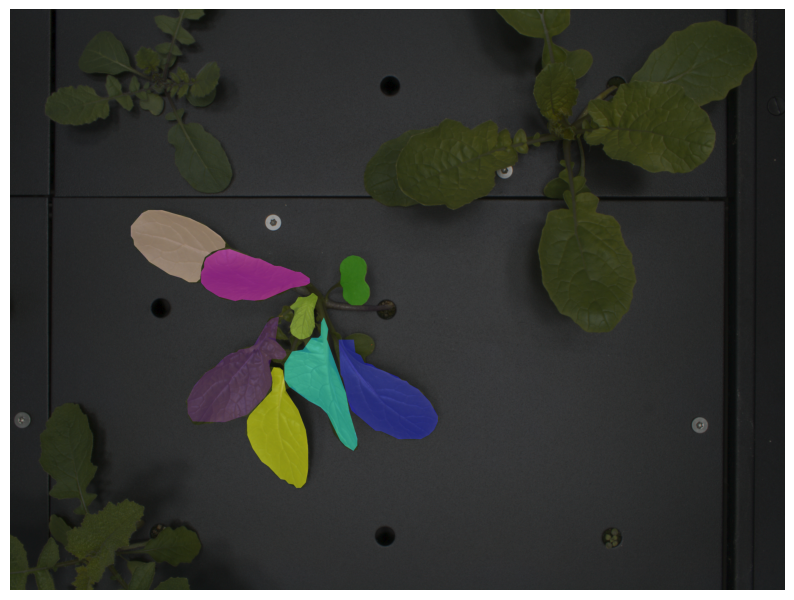

In [22]:
image = imageio.imread(images[-1])
with open(result_path / f"{images[-1].stem}.json") as file:
    labelme_annotation = json.load(file)

mask = np.zeros((image.shape[0], image.shape[1]), dtype=np.uint8)
countours = [shape["points"] for shape in labelme_annotation["shapes"]]
for i, countour in enumerate(countours):
    cv2.drawContours(mask, [np.array(countour)], 0, i + 1, -1)

plt.figure(figsize=(10, 10))
plt.tight_layout()
plt.axis("off")
plt.imshow(image)
plt.imshow(label2rgb(mask), alpha=0.4)